### Embryo zebrafish development data: https://pubmed.ncbi.nlm.nih.gov/37468546/

In [1]:
import sys
import os
sys.path.append(os.path.abspath("../../src/utils"))
from preprocess import *  
from plotting import *
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from pathlib import Path


data_dir = "../../data/embryo/raw/"
plot_dir = "../../data/embryo/plots/"
os.makedirs(plot_dir, exist_ok=True)

#### Load ATAC data and metadata

In [2]:
atac_data_path = os.path.join(data_dir, "atac_peak_matrix_complete_sparse.csv")
atac_data_df = pd.read_csv(atac_data_path)

meta_path = os.path.join(data_dir, "atac_all.metaData.txt")
atac_metadata_df = pd.read_csv(meta_path, index_col=0)


Map ATAC Cells: Assign each cell a pseudobulk, developmental stage + cell type using the authors' celltype assignment

In [3]:
atac_metadata_df = (
    atac_metadata_df
    [['celltype', 'predictedCell', 'predictedGroup']]
    .rename(columns={
        'celltype': 'atac_cell_type',
        'predictedCell': 'rna_matching_cell',
        'predictedGroup': 'rna_cell_type'
    })
    .reset_index(names="atac_cell")
)

def extract_stage(cell_id, delimiter='h', pos=0):
    return str(cell_id).split(delimiter)[pos].replace('h', '')

atac_metadata_df = atac_metadata_df.assign(
    rna_stage=lambda df: df['rna_matching_cell'].apply(extract_stage, args=('h', 0)),
    atac_stage=lambda df: df['atac_cell'].apply(extract_stage, args=('hpf', 0)),
    pseudobulk=lambda df: df['atac_stage'] + '_' + df['atac_cell_type']
)

atac_metadata_df.head()


,atac_cell,atac_cell_type,rna_matching_cell,rna_cell_type,rna_stage,atac_stage,pseudobulk
0,3hpf_1#3hpf_1_merge_BC0443_N27,blastomere,6h_3 CELL4645_N1 _,margin,6,3,3_blastomere
1,3hpf_1#3hpf_1_merge_BC0069_N07,blastomere,3h1_CELL1337_N1_3h1,blastomere,3,3,3_blastomere
2,3hpf_1#3hpf_1_merge_BC0033_N05,blastomere,3h1_CELL1337_N1_3h1,blastomere,3,3,3_blastomere
3,3hpf_1#3hpf_1_merge_BC0028_N08,blastomere,3h1_CELL1197_N1_3h1,blastomere,3,3,3_blastomere
4,3hpf_1#3hpf_1_merge_BC0264_N08,blastomere,3h1_CELL1197_N1_3h1,blastomere,3,3,3_blastomere


Aggregate accessibility signals from all cells in a pseudobulk (by pseudobulk mean)

In [4]:
atac_data_df = atac_data_df.merge(
    atac_metadata_df[['atac_cell', 'pseudobulk', 'atac_cell_type']],
    left_on='Cell', right_on='atac_cell', how='left'
)

# mean accessibility per pseudobulk
pseudobulk_matrix = (
    atac_data_df.groupby(['Peak', 'pseudobulk'])['Accessibility']
    .mean()  
    .unstack(fill_value=0)
)
# cell counts per pseudobulk
cell_counts = atac_data_df.groupby('pseudobulk')['Cell'].nunique().sort_values(ascending=False)


Boxplots: Distribution of total read count per cell in each pseudobulk - Colored by cell type
* Sorted by the most populated pseudobulks to the least
* Wider boxes might indicate either low quality cell type assignment **or** diverse chromatin accessibility behavior inside the pseudobulk (sub-categories)
* Narrow boxes indicate consistent pseudobulks --> more reliable especially on the right side of the plot (more cells)

❓ Is it a good idea to quantile normalize here?

/sasselab3/home/mourouzidou/zebrafish_development/src/utils/plotting.py:61: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_xticklabels(


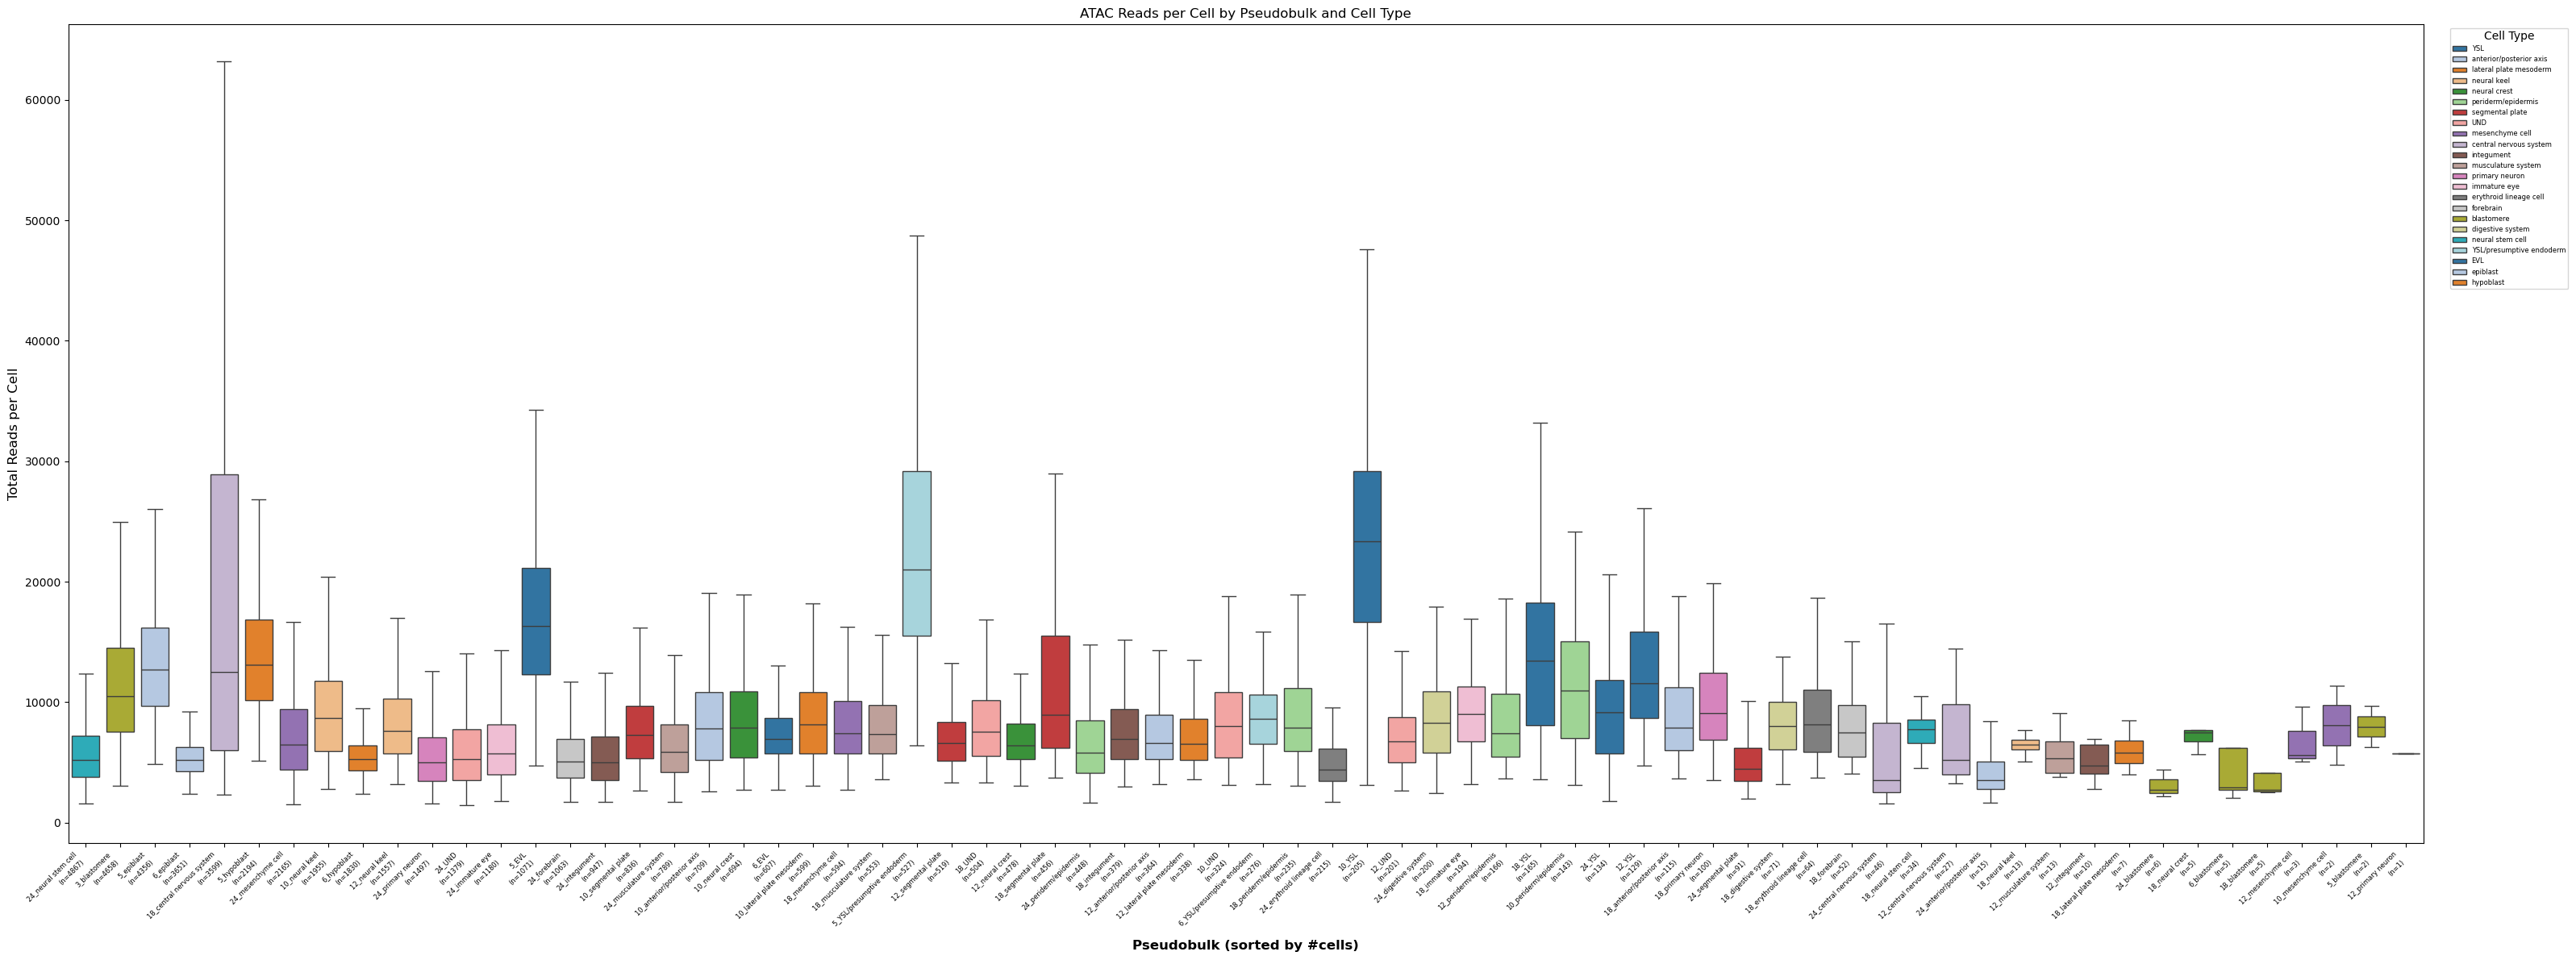

In [5]:
plot_pseudobulk_cell_read_distributions(atac_data_df, atac_metadata_df, save_path=plot_dir, show = True)

Scatterplots: Pseudobulk Cell Read Statistics vs Number of Cells

1. Median Reads per Cell: The mean depth of cells in each pseudobulk.
2. Standard Deviation (Std): The variability in total reads per cell within each pseudobulk.
3. Max-Min Range: The total reads per cell range in each pseudobulk.

Assists pseudobulking quality control.

There seems no clear trend between the pseuodbulk size and the variability of reads per cell --> suggests that the variability within pseudobulk is not due to small sample size.  
In that case we would expect the variabiility (figure 2 & 3) to decrease as the sample size increases. Thus heterogeneity could either derive from biological signal or cell missclassification.


 ❓Could this indicate that the cause of heterogeneity in some pseudobulks is biological signal? If not, is it safe to discard heterogenious pseudobulks?



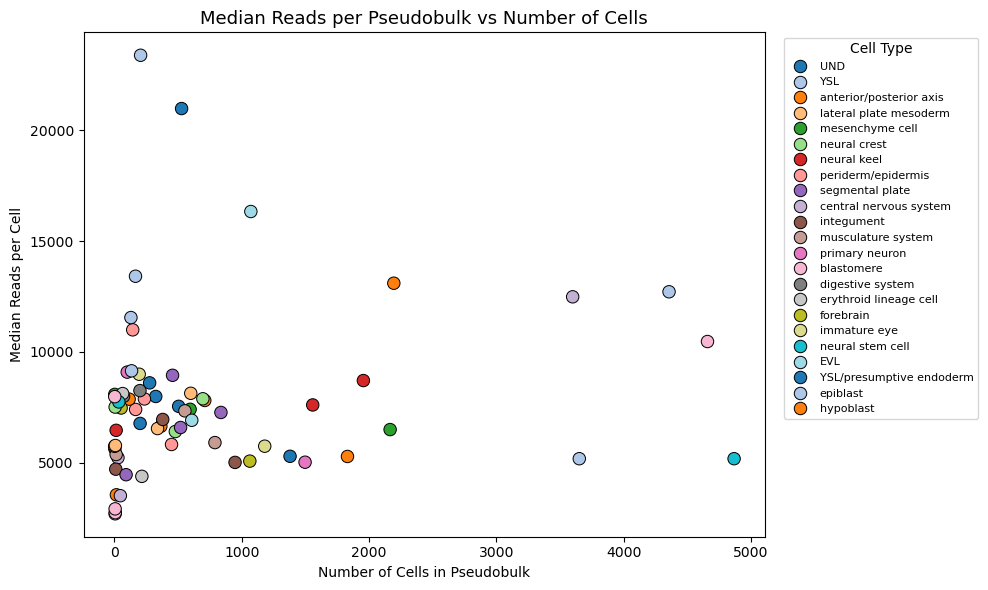

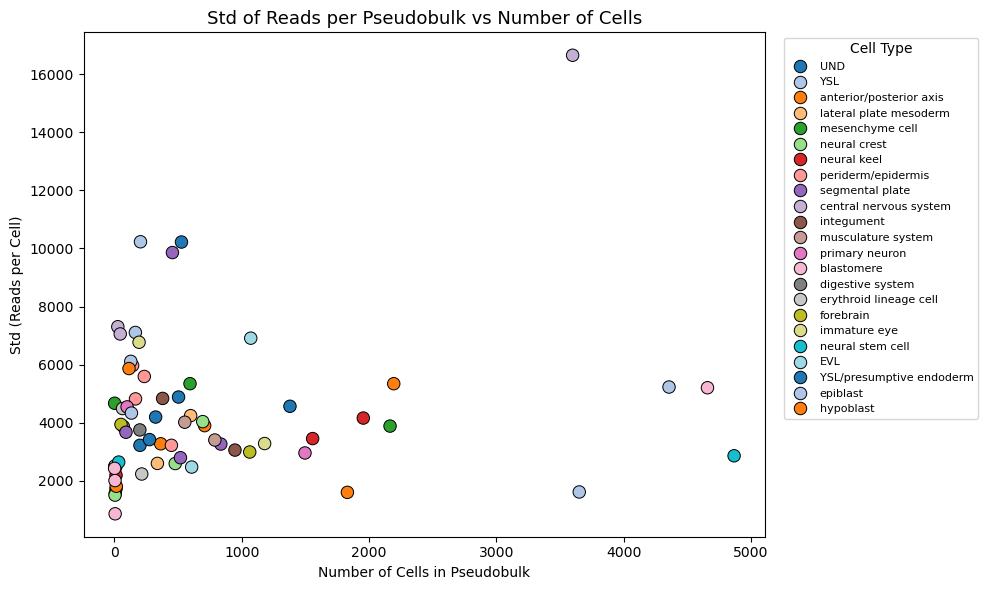

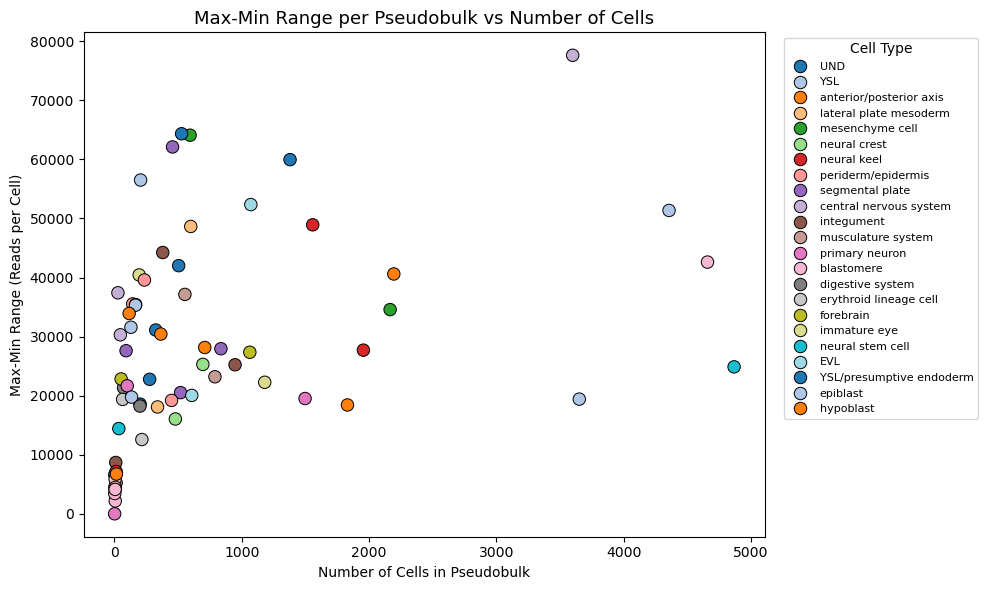

In [6]:
plot_pseudobulk_agg_stats(atac_data_df, atac_metadata_df, save_path=plot_dir, show=True)

### Plasticity check

Each boxplot shows, for a given cell type, how sequencing depth varies across developmental stages. 

* For most cell types, there is a general trend of decreasing total reads per cell as the developmental stage progresses.


Expectation:

* It is expected for earlier embryonic stages to be have a higher regulatory activity to facilitate normal cell differentiation. This could ezplain the decreasing depth trend through stages for a certain cell type.

❓ Does this make biological sense? Can this help us filter or confirm the quality of pseudobulks?

count    50637.000000
mean      9666.958963
std       7498.662092
min       1429.000000
25%       5098.000000
50%       7498.000000
75%      11699.000000
max      79956.000000
Name: Accessibility, dtype: float64


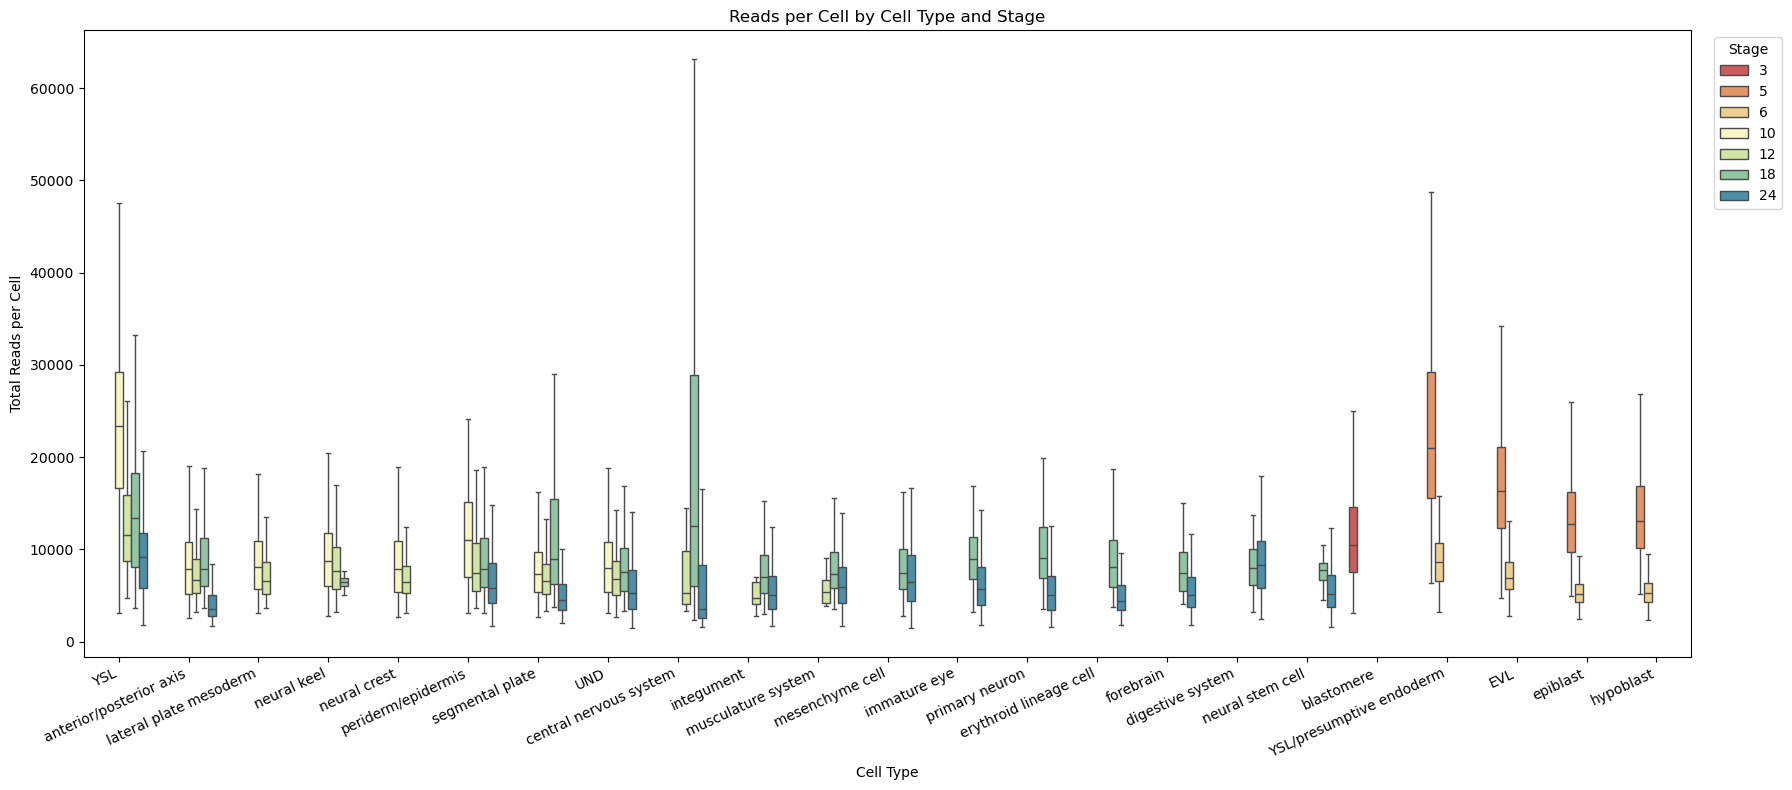

In [7]:
total_per_cell = atac_data_df.groupby('Cell')['Accessibility'].sum()
print(total_per_cell.describe())

plot_reads_per_cell_by_celltype_and_stage(
    total_per_cell,
    atac_metadata_df,
    min_cells_per_group=10,
    figsize=(18, 8),
    save_path = '../../data/embryo/plots/reads_per_cell_by_celltype_and_stage.png',
    show=True)

In [8]:

atac_data_cpm = cpm_normalize_sparse(atac_data_df)

pseudo_cpm = aggregate_atac_to_pseudobulk(atac_data_cpm, value_col='CPM')

In [22]:
# cpm NO quantile normalization
cpm_raw = pseudo_cpm.copy()  # raw

cpm_log = pseudo_cpm.copy()  # log
cpm_log = np.log1p(pseudo_cpm)

# cpm QUANTILE normalization
cpm_Nolog_Qn = quantile_normalize(cpm_raw) # raw

cpm_log_Qn = quantile_normalize(cpm_log)   # log


In [26]:
# convert cpm_Nolog_Qn and cpm_log_Qn to DataFrames
cpm_Nolog_Qn = pd.DataFrame(cpm_Nolog_Qn, index=pseudo_cpm.index, columns=pseudo_cpm.columns)
cpm_log_Qn= pd.DataFrame(cpm_log_Qn, index=pseudo_cpm.index, columns=pseudo_cpm.columns)

Boxplot showing the CPM (cell's accessibility devided by the total number of reads and multiplied by 100) aggregated (by mean) dataset
* before and after logging the pseudobulks' accessibility values
* before and after quantile normalizing

x-axis: pseudobulks sorted by cell number in them

y-axis: accessibility values

/sasselab3/home/mourouzidou/zebrafish_development/src/utils/plotting.py:246: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_xticklabels(x_labels, rotation=45, ha='right', fontsize=6)


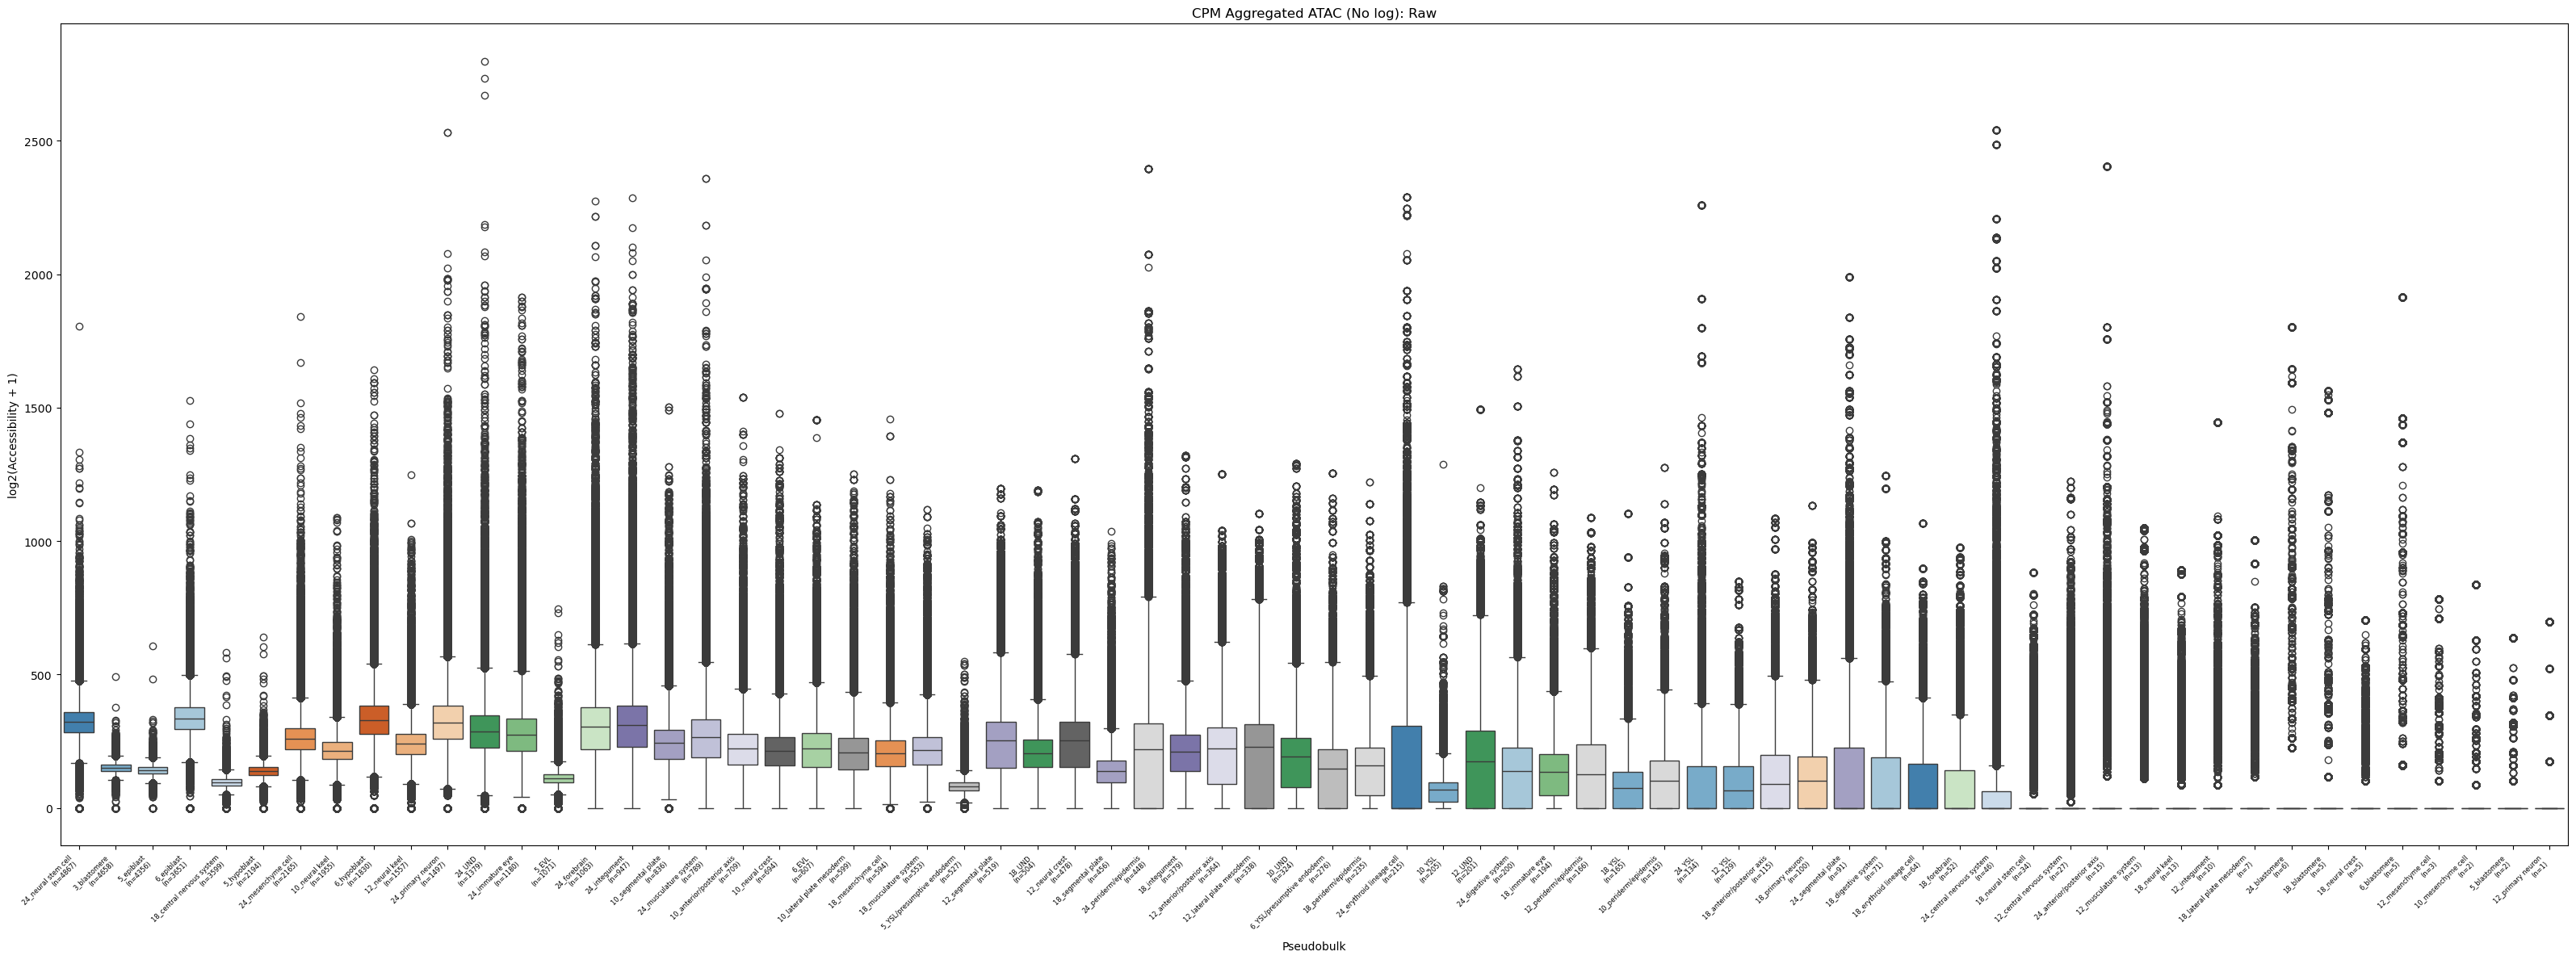

/sasselab3/home/mourouzidou/zebrafish_development/src/utils/plotting.py:246: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_xticklabels(x_labels, rotation=45, ha='right', fontsize=6)


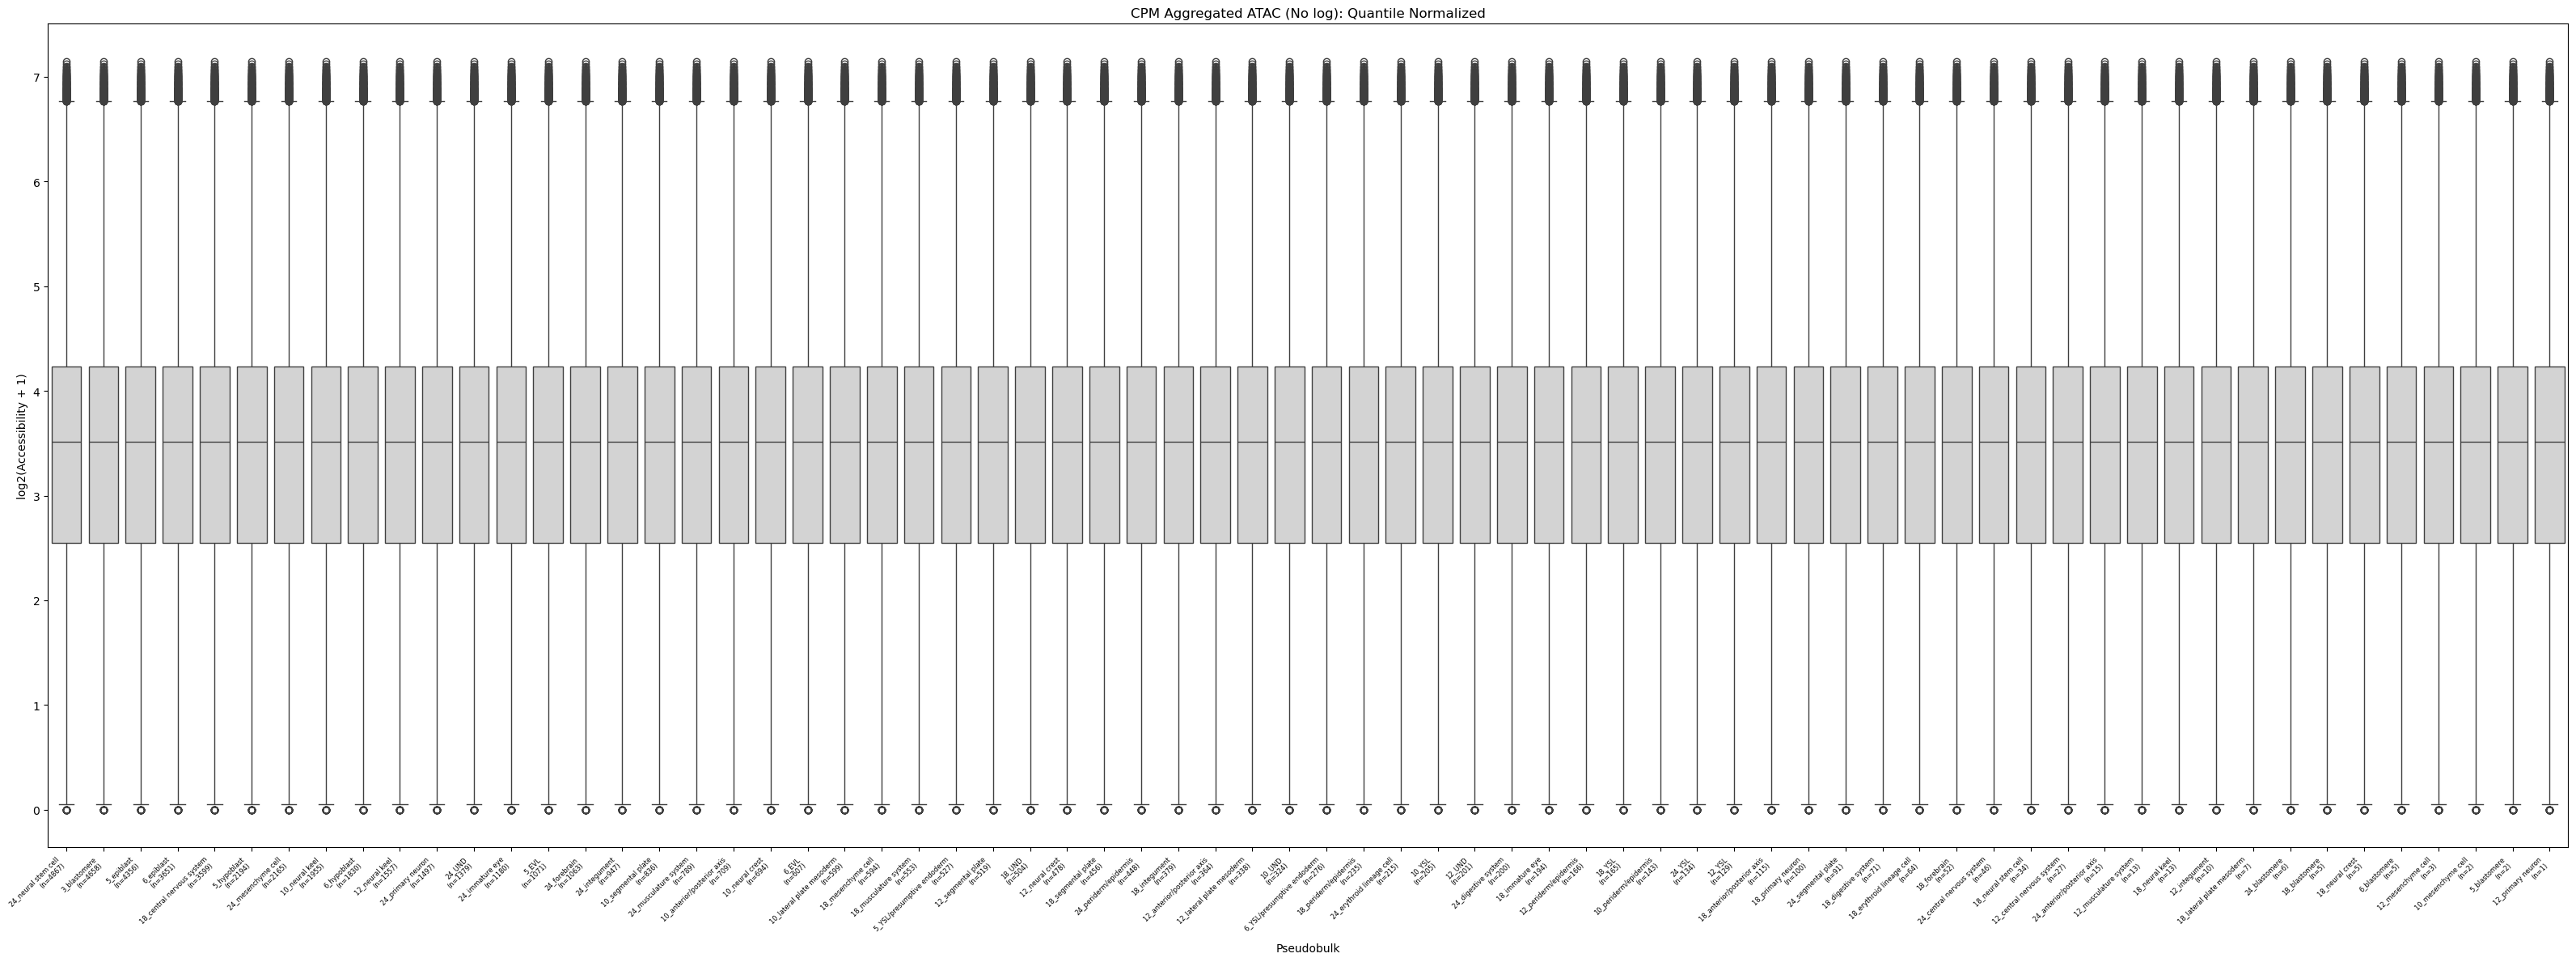

/sasselab3/home/mourouzidou/zebrafish_development/src/utils/plotting.py:246: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_xticklabels(x_labels, rotation=45, ha='right', fontsize=6)


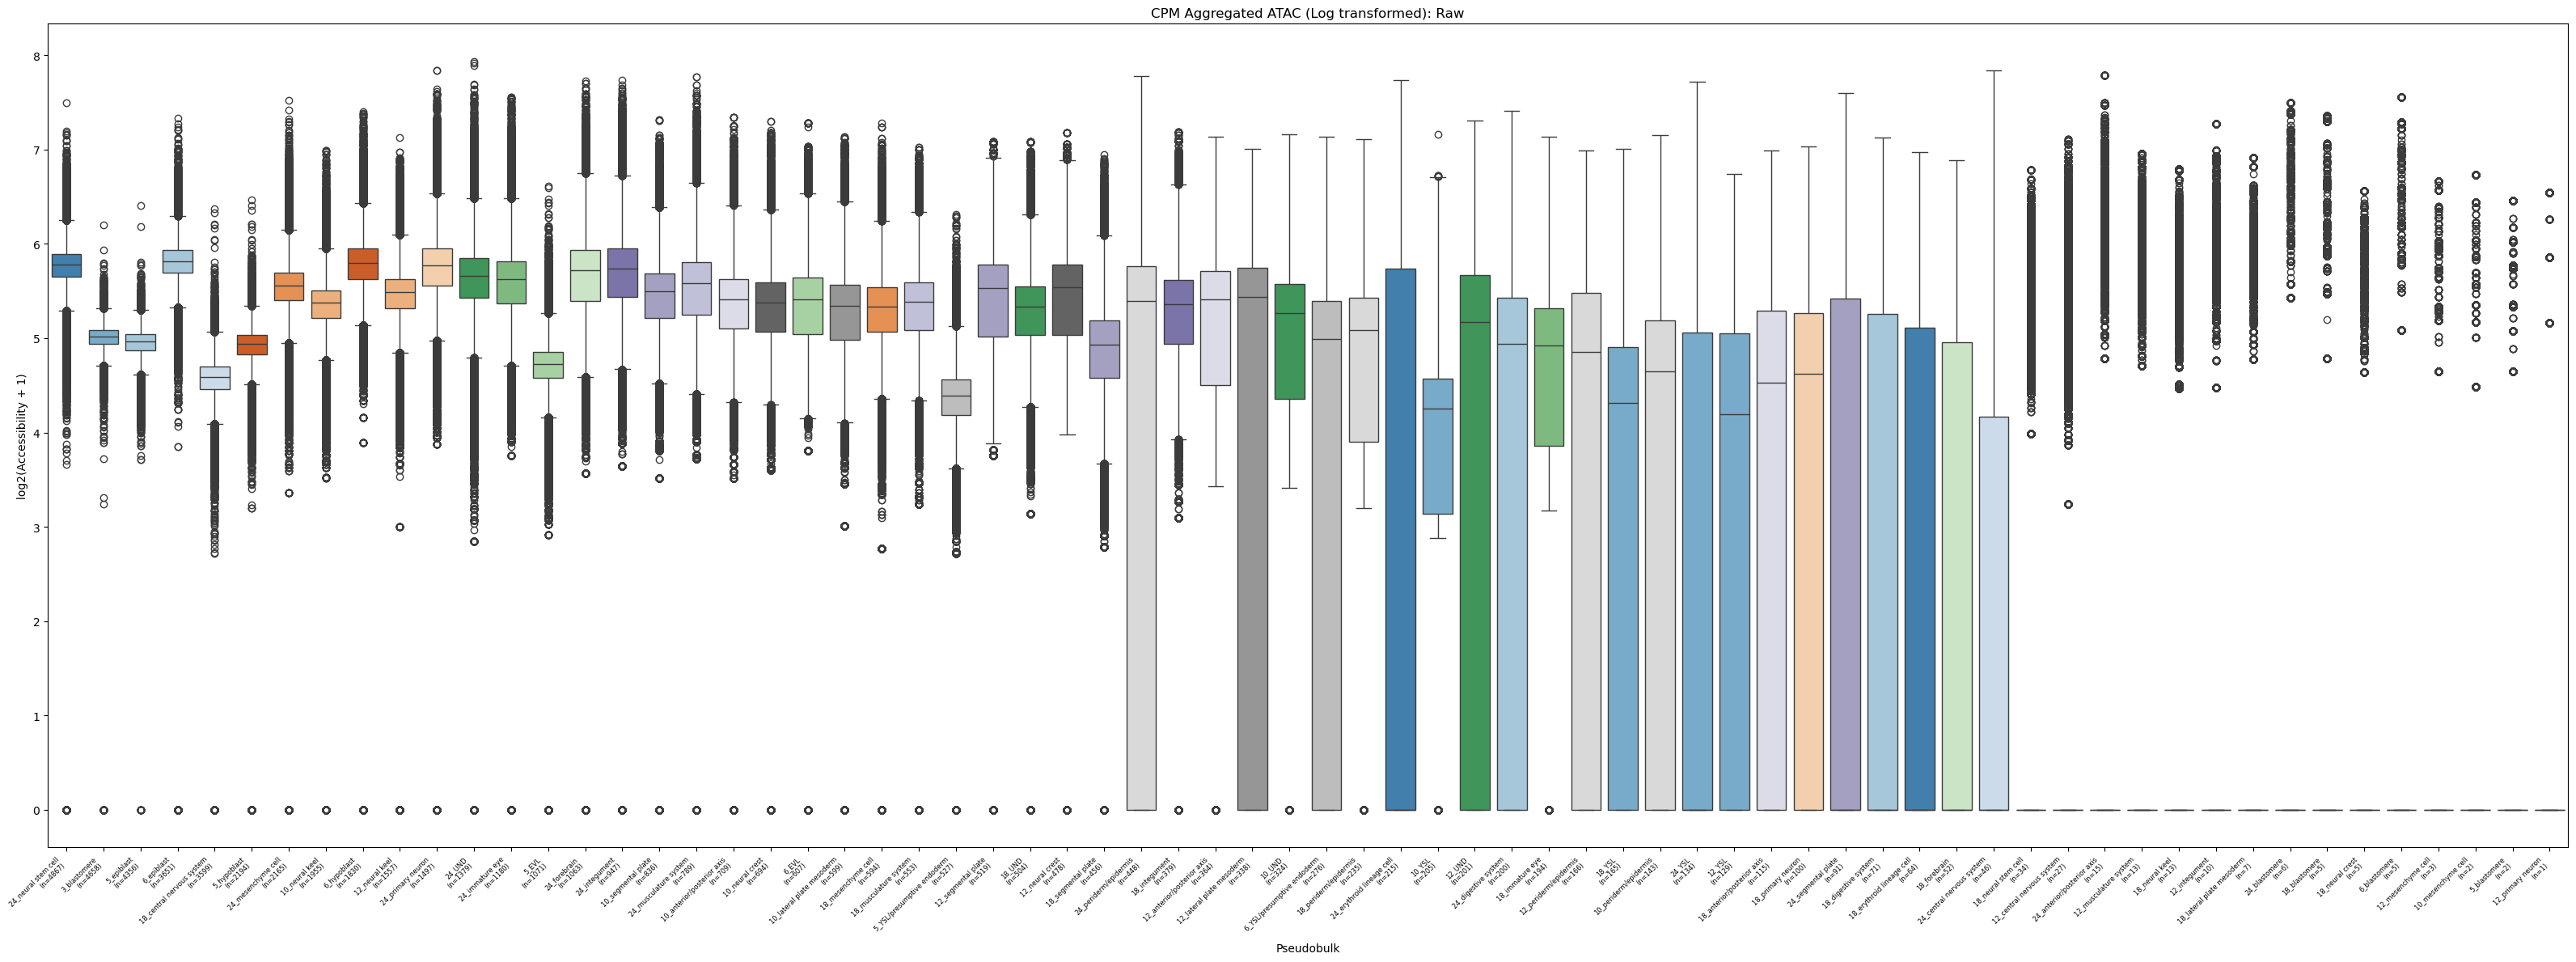

/sasselab3/home/mourouzidou/zebrafish_development/src/utils/plotting.py:246: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_xticklabels(x_labels, rotation=45, ha='right', fontsize=6)


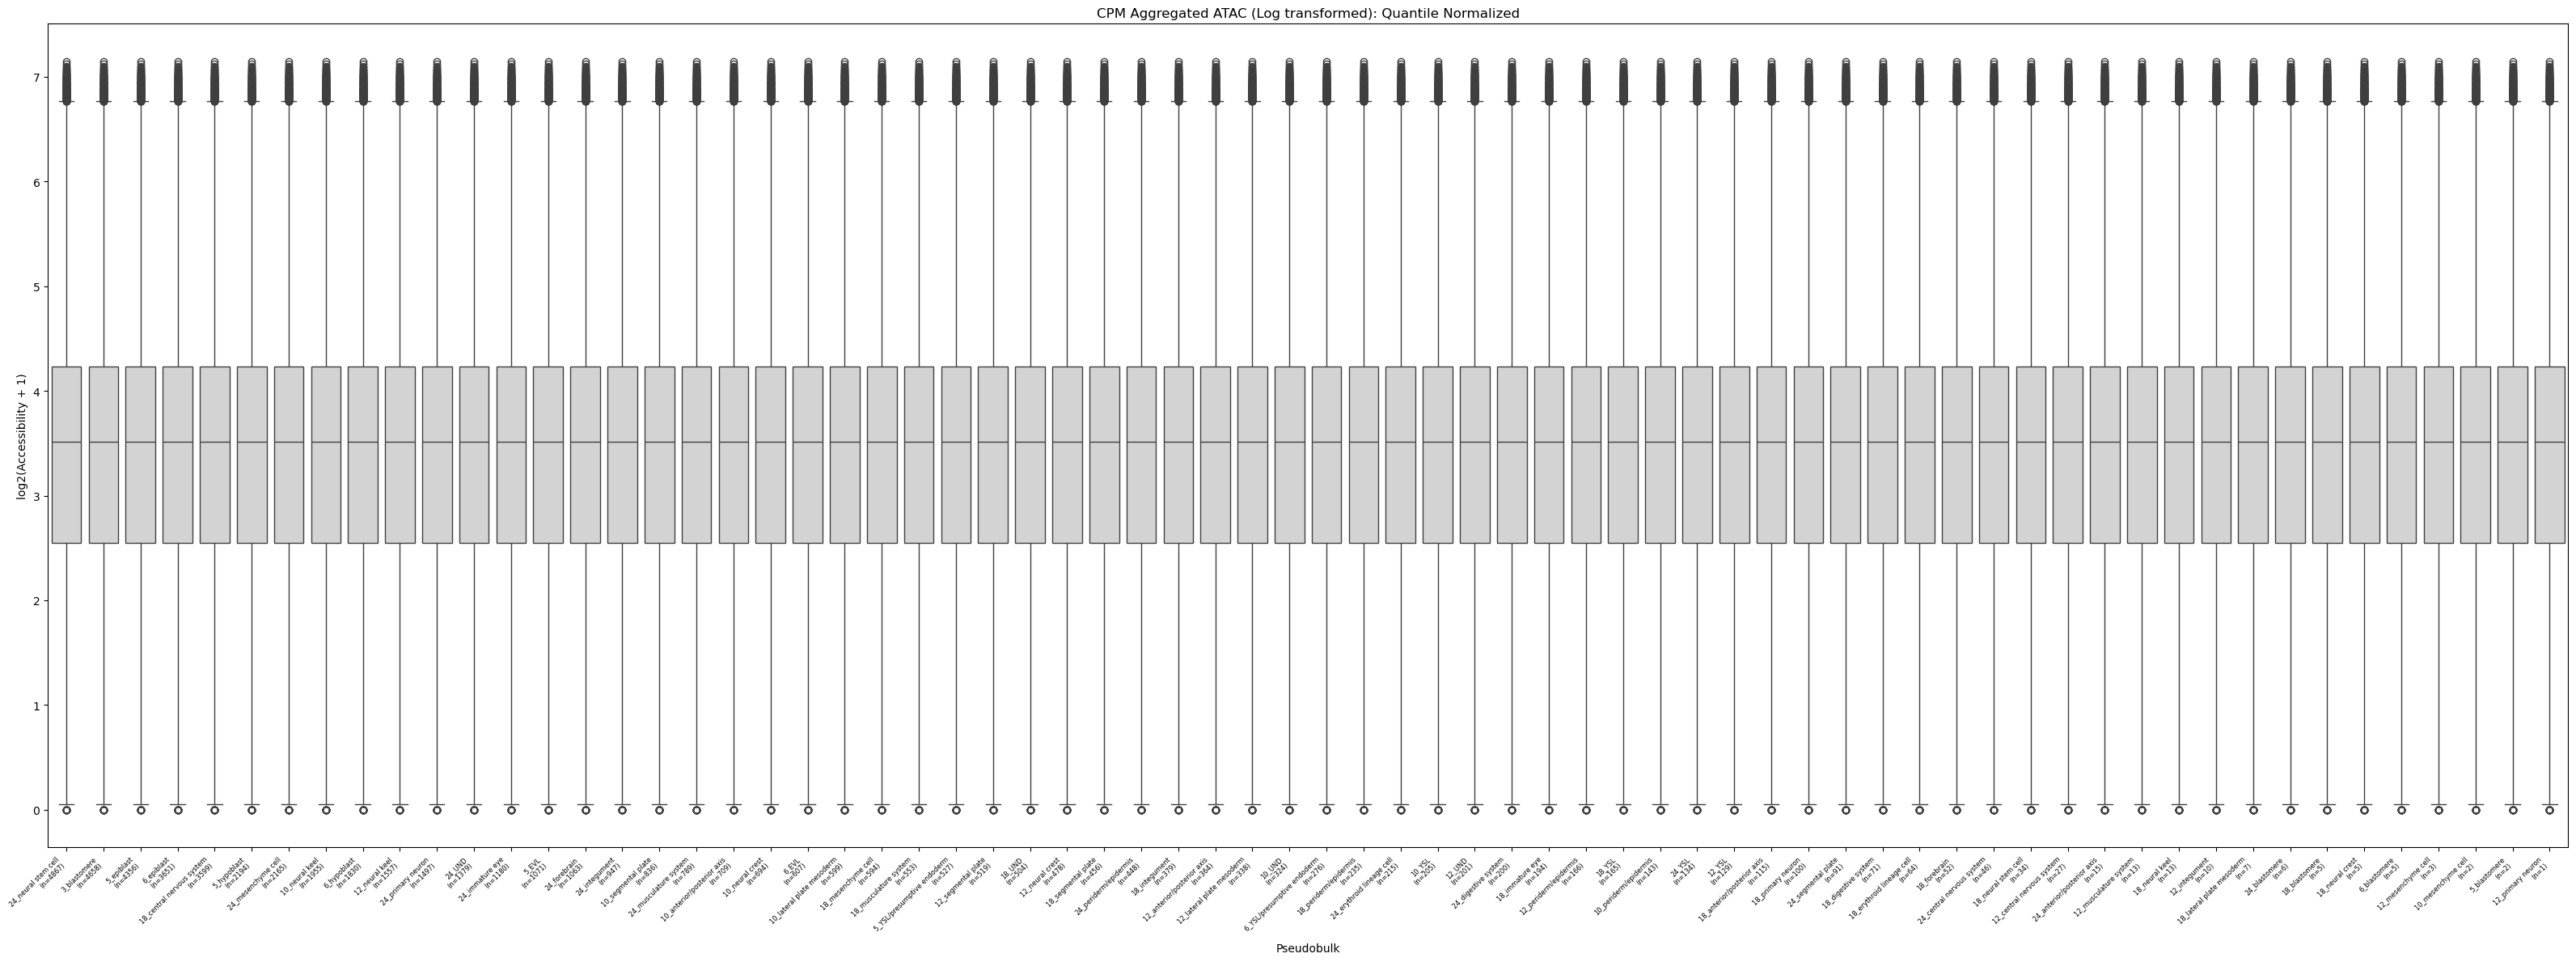

In [ ]:
plot_dir = "../../data/embryo/plots"
pseudobulk_counts = atac_metadata_df['pseudobulk'].value_counts().to_dict()

plot_distributions(df_raw=cpm_nolog, df_quant=cpm_Nolog_Qn, 
    title_prefix="CPM Aggregated ATAC (No log)",
    pseudobulk_counts=pseudobulk_counts,
)

plot_distributions(df_raw=cpm_log, df_quant=cpm_Nolog_Qn, 
    title_prefix="CPM Aggregated ATAC (Log transformed)",
    pseudobulk_counts=pseudobulk_counts)


In [27]:
# coordinate dataframe from atac_data_df
peak_coords = (
    atac_data_df[['Peak']]
    .drop_duplicates()
    .assign(
        chromosome=lambda df: df['Peak'].str.extract(r'(chr[\w]+)'),
        start=lambda df: df['Peak'].str.extract(r':(\d+)-')[0].astype(int),
        end=lambda df: df['Peak'].str.extract(r'-(\d+)')[0].astype(int)
    )
)
def attach_coords(matrix_df):
    return (
        matrix_df.reset_index()
        .merge(peak_coords, on='Peak', how='left')
        .dropna(subset=['chromosome', 'start', 'end'])
    )
attach_coords(cpm_Nolog_Qn)

,Peak,10_UND,10_YSL,10_anterior/posterior axis,10_lateral plate mesoderm,10_mesenchyme cell,10_neural crest,10_neural keel,10_periderm/epidermis,10_segmental plate,...,5_epiblast,5_hypoblast,6_EVL,6_YSL/presumptive endoderm,6_blastomere,6_epiblast,6_hypoblast,chromosome,start,end
0,chr10:10002124-10002624,227.962051,181.654777,103.516212,190.998689,98.369401,154.247849,132.303713,355.770787,316.733675,...,139.263580,704.243012,99.664518,124.326180,98.172019,199.830441,310.269467,chr10,10002124,10002624
1,chr10:10003707-10004207,95.616241,79.235187,208.574945,36.067774,166.684623,99.750673,157.435801,51.546468,158.357203,...,95.529046,268.721257,25.731497,69.309024,166.314839,20.385610,14.365602,chr10,10003707,10004207
2,chr10:10004747-10005247,187.574108,79.178752,140.997044,121.030503,166.684159,197.013725,227.825319,144.481713,95.656937,...,93.515776,71.585907,150.388137,95.017435,166.314168,42.245950,25.201116,chr10,10004747,10005247
3,chr10:10008047-10008547,181.011130,79.179441,181.276390,131.624200,166.683802,238.482246,161.921147,230.470500,214.497428,...,161.910790,144.346132,130.881981,162.032084,166.313594,196.567754,303.837034,chr10,10008047,10008547
4,chr10:10009662-10010162,67.077045,79.180059,133.716737,36.068044,166.683408,81.294684,30.823509,169.408303,930.136161,...,132.904348,60.921275,54.335778,44.442009,166.312775,61.469511,14.291516,chr10,10009662,10010162
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
370053,chr9:998557-999057,67.056870,81.259353,71.338217,60.323235,98.373136,70.286536,434.838738,51.547825,340.154245,...,257.987979,87.433539,232.323085,126.123798,98.174456,204.507955,239.324525,chr9,998557,999057
370054,chr9:9989556-9990056,128.560820,186.652011,162.931413,610.216712,98.372359,76.104272,185.506834,196.227314,97.943797,...,89.399295,163.681794,148.517759,244.499259,98.173991,20.795192,62.367338,chr9,9989556,9990056
370055,chr9:9992990-9993490,82.180553,95.299294,54.726086,97.307785,98.371800,23.745042,66.327228,107.165296,33.171622,...,43.715343,64.717616,62.489876,44.426462,98.173605,111.050409,227.013775,chr9,9992990,9993490
370056,chr9:9997607-9998107,148.517759,239.485337,79.363866,58.766134,98.371106,23.738931,134.081381,305.942082,99.917246,...,169.022614,58.628052,101.381672,323.362322,98.173015,191.288553,68.978274,chr9,9997607,9998107


In [28]:
# FASTA files directory
fasta_dir = "../../data/genome"
save_dir = "../../data/embryo/processed"

expansion_length = 2000

# apply to each version and save 
df_nolog = attach_coords(cpm_raw)
nolog_seq = extract_centered_sequences(df_nolog, fasta_dir, expansion_length, save_dir)

df_log = attach_coords(cpm_log)
log_seq = extract_centered_sequences(df_log, fasta_dir, expansion_length, save_dir)

df_nolog_qn = attach_coords(cpm_Nolog_Qn)
nolog_Qn_seq = extract_centered_sequences(df_nolog_qn, fasta_dir, expansion_length, save_dir)

df_log_qn = attach_coords(cpm_log_Qn)
log_Qn_seq = extract_centered_sequences(df_log_qn, fasta_dir, expansion_length, save_dir)


### Use [Danio_rerio.GRCz11.111.chr.gtf](https://ftp.ensembl.org/pub/release-111/gtf/danio_rerio/) file to extract a list of TSS positions.
 - consider only gene entries
 - for the + strand take the 'start' position 
 - for the - strand take the 'end' position

In [29]:
gtf_path = "../../data/genome/Danio_rerio.GRCz11.111.chr.gtf"


In [30]:
gene_info = extract_gene_info_from_gtf(gtf_path)
gene_info.head()

,chrom,start,end,tss_position,gene_name,gene_id
0,4,30402837,30403763,30402837,CR383668.1,ENSDARG00000103202
1,4,1722899,1730920,1722899,fgfr1op2,ENSDARG00000009657
2,4,40758511,40759309,40758511,AL845295.2,ENSDARG00000096472
3,4,11099041,11106856,11106856,si:dkey-21h14.12,ENSDARG00000096156
4,4,40835393,40839221,40835393,si:dkey-285e18.2,ENSDARG00000076160


In [91]:
dist = 1000  # distance threshold for TSS annotation

ann_1000 = annotate_peaks_with_region_types(log_seq, gene_info, distance_threshold=dist)
# values in genomic_context 
print(ann_10_000['genomic_context'].value_counts())
# values in region_types
print(ann_10_000['region_type'].value_counts())


genomic_context
intragenic    240801
intergenic    129257
Name: count, dtype: int64
region_type
enhancer    229252
promoter    140806
Name: count, dtype: int64


In [92]:
# reorder columns for better readability - bring peak metadata to the front
meta_cols = ['Peak', 'chromosome', 'start', 'end', 'sequence', 'region_type', 'genomic_context']
remaining_cols = [col for col in ann_1000.columns if col not in meta_cols]
new_order = meta_cols + remaining_cols
ann_1000 = ann_1000[new_order]
ann_1000.head()


,Peak,chromosome,start,end,sequence,region_type,genomic_context,10_UND,10_YSL,10_anterior/posterior axis,...,5_EVL,5_YSL/presumptive endoderm,5_blastomere,5_epiblast,5_hypoblast,6_EVL,6_YSL/presumptive endoderm,6_blastomere,6_epiblast,6_hypoblast
0,chr10:10002124-10002624,10,10002124,10002624,TGCTTTCTCATGCAGCAAACACGTGTGCATAATAAGACATTTTGTG...,enhancer,intragenic,5.736278,4.528056,5.269069,...,4.539703,4.008559,0.0,4.976241,5.418043,5.211814,4.865353,0.0,5.949215,6.171589
1,chr10:10003707-10004207,10,10003707,10004207,TAGCTTTTAACAATAAAATAAACAAACAAACAAACAATTACAATAA...,enhancer,intragenic,4.805037,0.000000,5.682519,...,4.580894,4.709518,0.0,4.899029,5.129559,0.000000,0.000000,0.0,5.327934,0.000000
2,chr10:10004747-10005247,10,10004747,10005247,TTTCTGCTCATAGCTGGATCCATTTCCGCTGCTCCTGTCGCCACAT...,enhancer,intragenic,5.563784,0.000000,5.459051,...,4.633017,4.703440,0.0,4.894606,4.798491,5.492745,4.302743,0.0,5.535282,5.139282
3,chr10:10008047-10008547,10,10008047,10008547,ATCTCTAATAAAGCTGTGGTACTTAAATAAAGCTCAGTTGGAATTA...,enhancer,intragenic,5.534709,0.000000,5.596153,...,4.672662,0.000000,0.0,5.007587,4.962676,5.398240,5.242149,0.0,5.943246,6.161794
4,chr10:10009662-10010162,10,10009662,10010162,CTAACATTTGAGCGCTATTGAGCACAGTCTTAAACAGCGCTGGTTT...,enhancer,intragenic,0.000000,0.000000,5.419276,...,4.698469,3.901667,0.0,4.963921,4.760256,4.219070,0.000000,0.0,5.621454,0.000000


Compute the total promoter depth and the total enhancer depth for each cell 
- dist > 10kb => enhancer else promoter

In [93]:
peak_region = ann_1000.set_index('Peak')['region_type'].to_dict()
atac_data_df = atac_data_df.copy()
atac_data_df['region_type'] = atac_data_df['Peak'].map(peak_region)

promoter_counts = (
    atac_data_df[atac_data_df['region_type'] == 'promoter']
    .groupby('Cell')['Accessibility'].sum()
    .rename('total_promoter_accessibility')
    .reset_index()
)

enhancer_counts = (
    atac_data_df[atac_data_df['region_type'] == 'enhancer']
    .groupby('Cell')['Accessibility'].sum()
    .rename('total_enhancer_accessibility')
    .reset_index()
)

print(promoter_counts.head())
print(enhancer_counts.head())


                         Cell  total_promoter_accessibility
0  10hpf_1#10hpf_1_BC0020_N02                          9513
1  10hpf_1#10hpf_1_BC0021_N02                          6413
2  10hpf_1#10hpf_1_BC0023_N01                          7655
3  10hpf_1#10hpf_1_BC0024_N02                         11941
4  10hpf_1#10hpf_1_BC0026_N01                         10059
                         Cell  total_enhancer_accessibility
0  10hpf_1#10hpf_1_BC0020_N02                         30194
1  10hpf_1#10hpf_1_BC0021_N02                         20031
2  10hpf_1#10hpf_1_BC0023_N01                         25060
3  10hpf_1#10hpf_1_BC0024_N02                         35624
4  10hpf_1#10hpf_1_BC0026_N01                         28883


In [94]:
# Merge cell metadata to get cell type and pseudobulk for each cell
cell_meta_cols = ['Cell', 'atac_cell_type', 'pseudobulk']
cell_meta = atac_metadata_df.rename(columns={'atac_cell': 'Cell'})[cell_meta_cols]

# Add metadata columns to counts tables
promoter_counts = promoter_counts.merge(cell_meta, on='Cell', how='left')
enhancer_counts = enhancer_counts.merge(cell_meta, on='Cell', how='left')


In [95]:
# Merge promoter and enhancer counts into a long-form DataFrame
def long_counts_df(promoter_counts, enhancer_counts):
    df_prom = promoter_counts[['Cell', 'total_promoter_accessibility', 'atac_cell_type', 'pseudobulk']].copy()
    df_prom = df_prom.rename(columns={'total_promoter_accessibility': 'total_accessibility'})
    df_prom['region_type'] = 'promoter'

    df_enh = enhancer_counts[['Cell', 'total_enhancer_accessibility', 'atac_cell_type', 'pseudobulk']].copy()
    df_enh = df_enh.rename(columns={'total_enhancer_accessibility': 'total_accessibility'})
    df_enh['region_type'] = 'enhancer'

    return pd.concat([df_prom, df_enh], ignore_index=True)

long_df = long_counts_df(promoter_counts, enhancer_counts)


In [96]:
import matplotlib.pyplot as plt
import seaborn as sns

def plot_grouped_enh_prom(
    long_df, 
    group_col, 
    figsize=(20,7), 
    show=True, 
    save_path=None,
    distance_cutoff=None,
    min_cells=1
):
    # Count number of cells in each group, filter for min_cells
    counts = long_df.groupby(group_col)['Cell'].nunique()
    counts = counts[counts >= min_cells].sort_values(ascending=False)
    if counts.empty:
        print(f"No groups found with at least {min_cells} cells.")
        return
    ordered_groups = counts.index.tolist()
    x_labels = [f"{grp}\n(n={counts[grp]})" for grp in ordered_groups]
    label_map = dict(zip(ordered_groups, x_labels))

    plt.figure(figsize=figsize)
    ax = sns.boxplot(
        data=long_df[long_df[group_col].isin(ordered_groups)],
        x=group_col,
        y='total_accessibility',
        hue='region_type',
        showfliers=False,
        order=ordered_groups,
        palette={'promoter':'#b396ac', 'enhancer':'#e6b6a8'}
    )
    ax.set_xticklabels([label_map[tick.get_text()] for tick in ax.get_xticklabels()],
                       rotation=45, ha='right')

    cutoff_str = f" | Distance cutoff: {distance_cutoff} bp" if distance_cutoff is not None else ""
    ax.set_title(
        f'Total Enhancer and Promoter Accessibility per Cell Grouped by {group_col}{cutoff_str}',
        fontsize=15
    )
    ax.set_xlabel(group_col.replace('_', ' ').title())
    ax.set_ylabel("Total Accessibility per Cell")
    plt.legend(title='Region Type')
    plt.tight_layout()
    if save_path:
        plt.savefig(save_path, dpi=150)
    if show:
        plt.show()
    else:
        plt.close()


/tmp/ipykernel_1637116/3261908858.py:33: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_xticklabels([label_map[tick.get_text()] for tick in ax.get_xticklabels()],


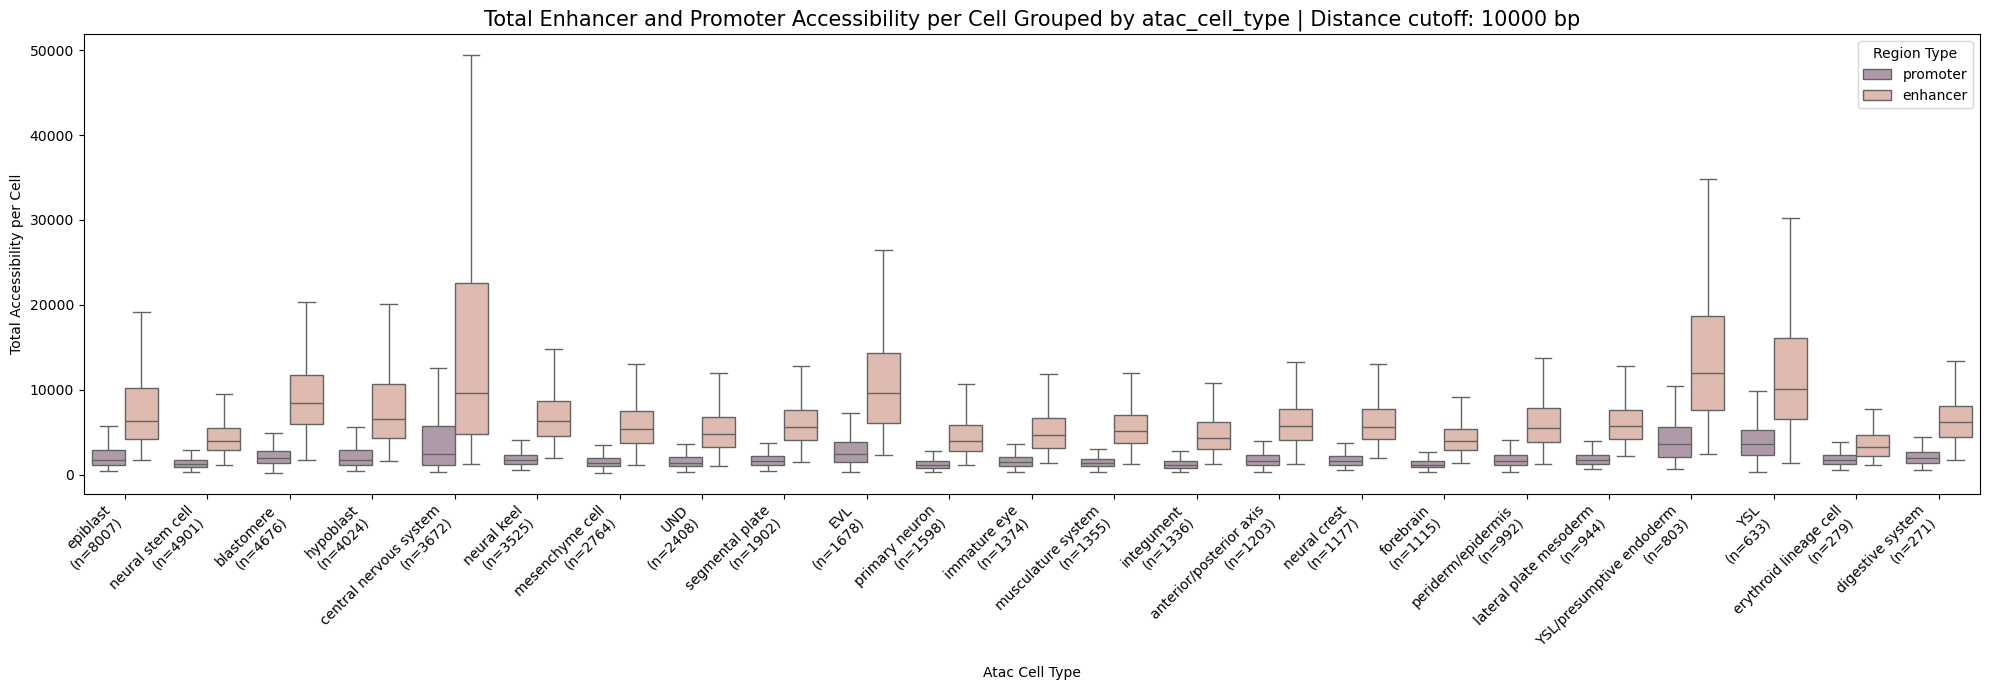

In [97]:
plot_grouped_enh_prom(long_df, 'atac_cell_type', distance_cutoff=10000, save_path='../../data/embryo/plots/prom_enh_atac_reads_celltypes.png')

/tmp/ipykernel_1637116/3261908858.py:33: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_xticklabels([label_map[tick.get_text()] for tick in ax.get_xticklabels()],


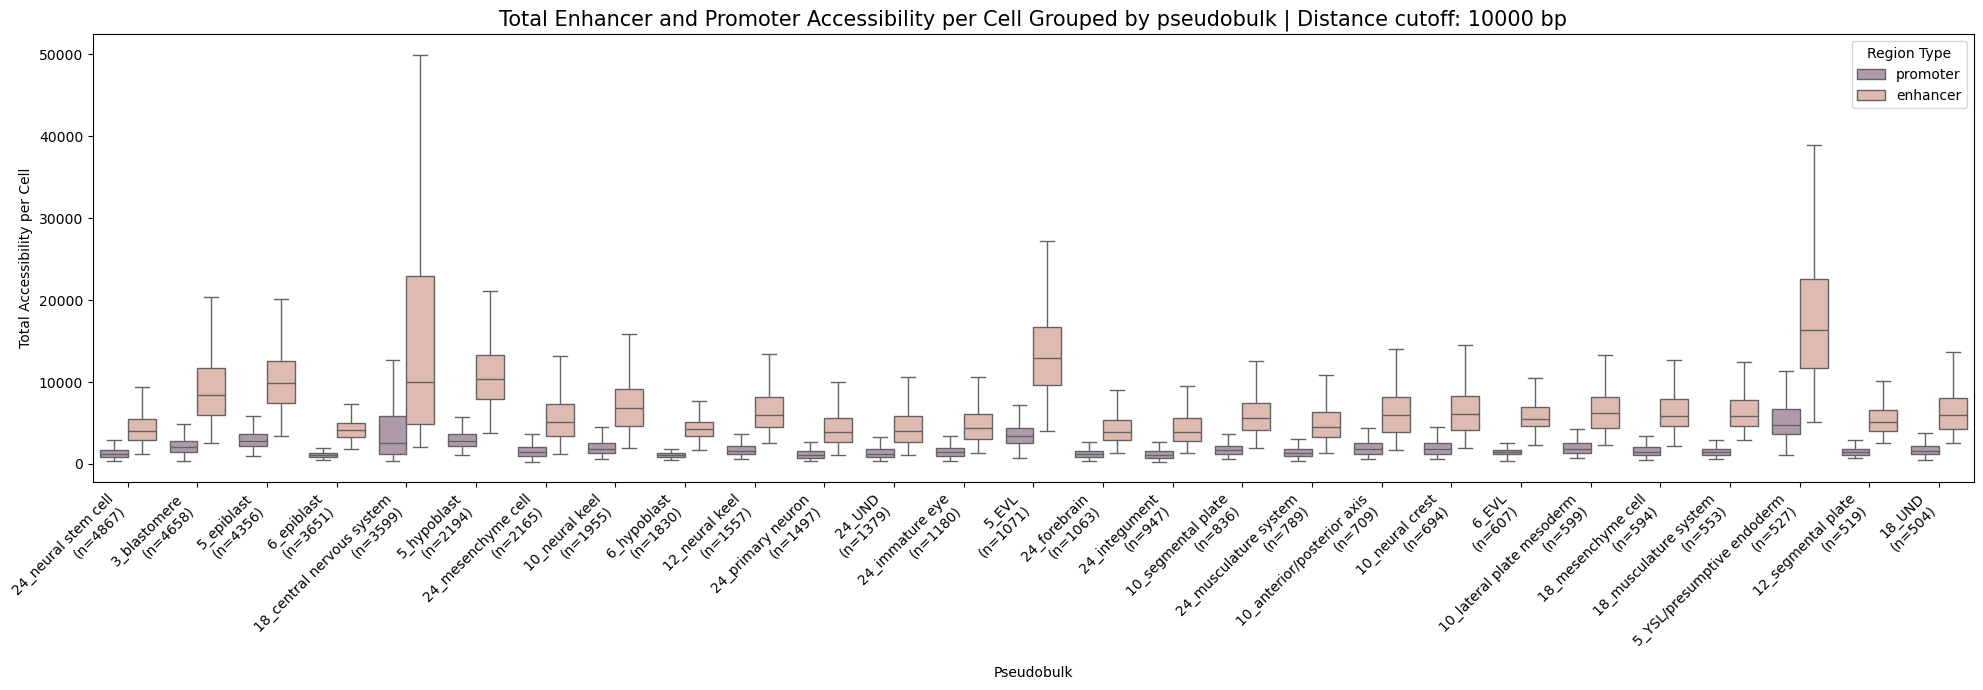

In [98]:
plot_grouped_enh_prom(long_df, 'pseudobulk', distance_cutoff=10000, min_cells=500)

In [ ]:



def plot_grouped_boxplot(
    long_df,
    value_for_plot,
    region_col='region_type',
    groupby='pseudobulk',
    figsize=(20,7),
    show=True,
    save_path=None,
    distance_cutoff=None,
    min_cells=1,
    region_palette=None,
):
    """Plots boxplot of (total/mean) accessibility per cell, grouped by groupby (celltype or pseudobulk)."""
    # Prepare label, sort groups by size
    group_counts = long_df.groupby(groupby)['Cell'].nunique().sort_values(ascending=False)
    ordered_groups = group_counts.index.tolist()
    x_labels = [f"{grp}\n(n={group_counts[grp]})" for grp in ordered_groups]
    label_map = dict(zip(ordered_groups, x_labels))

    if region_palette is None:
        palette = dict(zip(long_df[region_col].unique(), sns.color_palette("tab20", n_colors=long_df[region_col].nunique())))
    else:
        palette = region_palette

    plt.figure(figsize=figsize)
    ax = sns.boxplot(
        data=long_df[long_df[groupby].isin(ordered_groups)],
        x=groupby,
        y=value_for_plot,
        hue=region_col,
        showfliers=False,
        order=ordered_groups,
        palette=palette
    )
    ax.set_xticklabels([label_map[tick.get_text()] for tick in ax.get_xticklabels()],
                       rotation=45, ha='right')
    cutoff_str = f" | Distance cutoff: {distance_cutoff} bp" if distance_cutoff is not None else ""
    y_lab = ("Mean" if 'mean' in value_for_plot else "Total") + " Accessibility per Cell"
    ax.set_title(
        f'{y_lab} by {groupby.replace("_", " ").title()} ({region_col}){cutoff_str}',
        fontsize=15
    )
    ax.set_xlabel(groupby.replace('_', ' ').title())
    ax.set_ylabel(y_lab)
    plt.legend(title=region_col.replace("_", " ").title())
    plt.tight_layout()
    if save_path:
        plt.savefig(save_path, dpi=150)
    if show:
        plt.show()
    else:
        plt.close()


/tmp/ipykernel_1637116/2317156735.py:94: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_xticklabels([label_map[tick.get_text()] for tick in ax.get_xticklabels()],


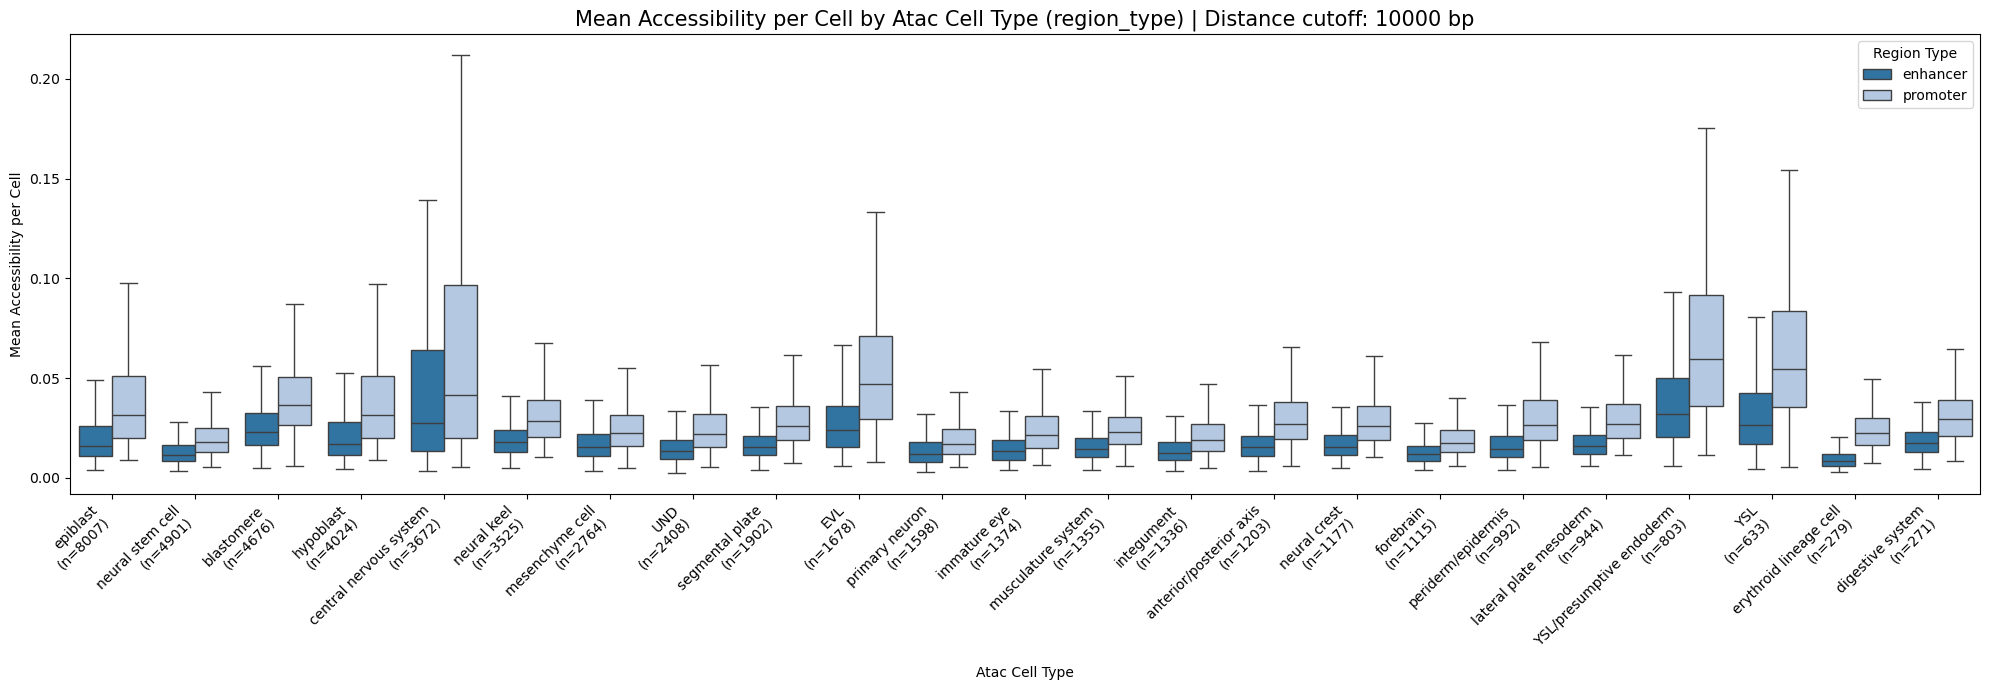

/tmp/ipykernel_1637116/2317156735.py:94: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_xticklabels([label_map[tick.get_text()] for tick in ax.get_xticklabels()],


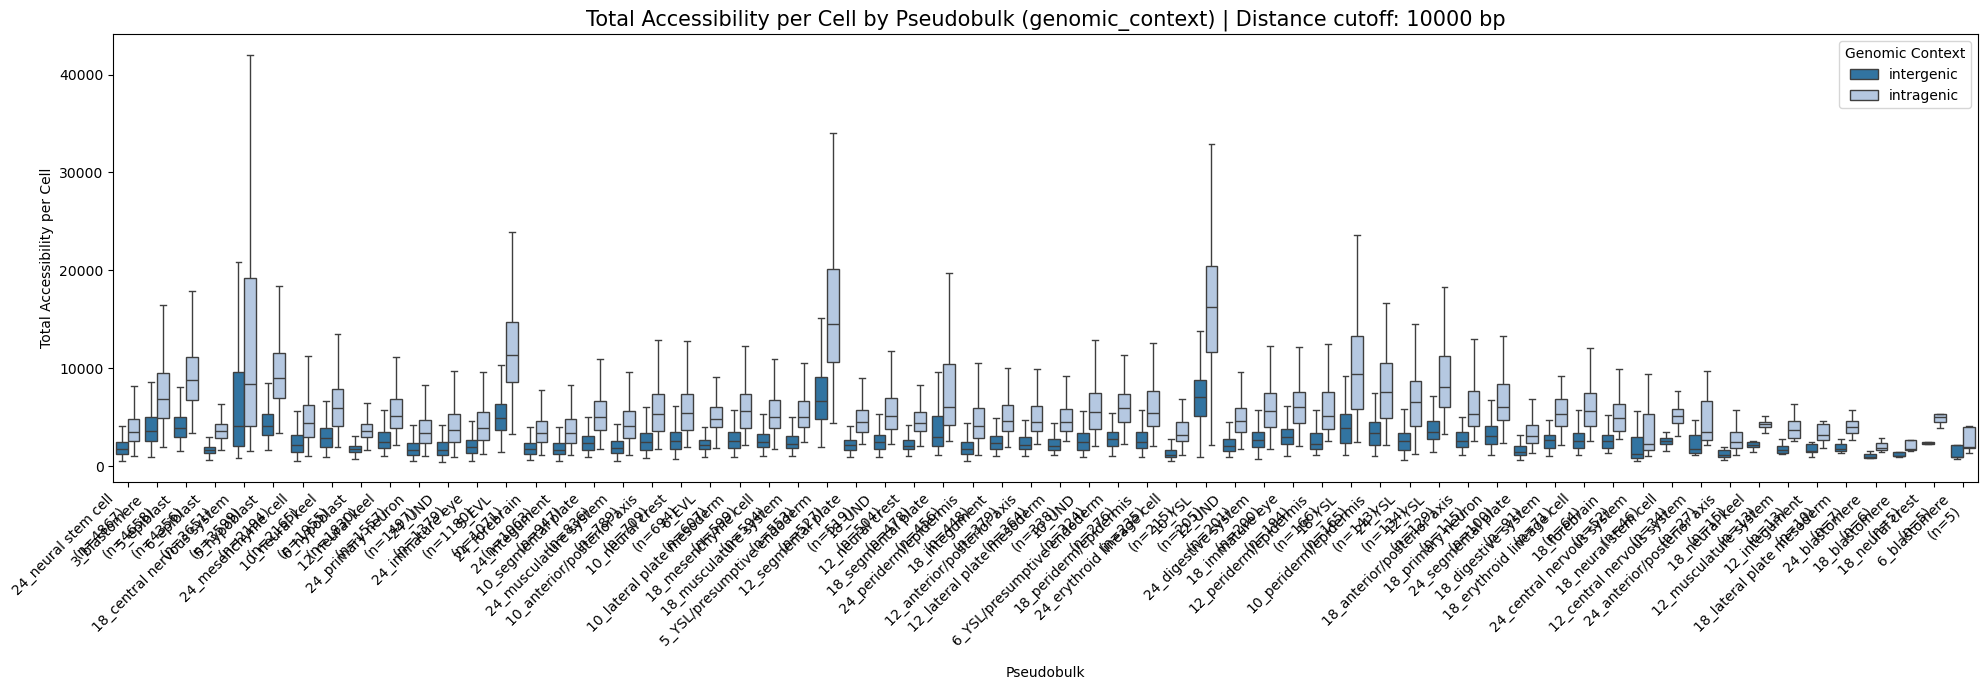

In [ ]:

distance_cutoff = 100

long_df, val_col = summarize_accessibility(atac_data_df, atac_metadata_df, region_col='region_type', groupby='atac_cell_type',
    normalize_by_num_peaks=True, min_cells=500)

plot_grouped_boxplot(long_df, val_col, region_col='region_type', groupby='atac_cell_type',
    show=True, save_path="atac_cell_type_mean_boxplot.png", distance_cutoff=distance_cutoff)

contexts_of_interest = ['intergenic', 'intragenic']



long_df2, val_col2 = summarize_accessibility(atac_data_df, atac_metadata_df, region_col='genomic_context', groupby='pseudobulk',
    normalize_by_num_peaks=False, min_cells=500, region_include=contexts_of_interest)

plot_grouped_boxplot(long_df2, val_col2, region_col='genomic_context', groupby='pseudobulk',
    show=True, save_path="pseudobulk_context_total_boxplot.png", distance_cutoff=distance_cutoff)


In [109]:

region_group_combos = [
    ('region_type', 'atac_cell_type'),
    ('region_type', 'pseudobulk'),
    ('genomic_context', 'atac_cell_type'),
    ('genomic_context', 'pseudobulk')
]

# Define palettes
palette_region_type = {'promoter': '#b396ac', 'enhancer': '#e6b6a8'}
palette_context = dict(zip(['intergenic', 'intragenic',], sns.color_palette("Set2", 2)))

contexts_of_interest = ['intergenic', 'intragenic']
distance_cutoffs = [1000000]
min_cells = 500

for dist in distance_cutoffs:
    for region_col, group_col in region_group_combos:
        normalize = True if region_col == 'region_type' else False
        region_include = None
        palette = palette_region_type if region_col == 'region_type' else palette_context

        # Optionally filter genomic context
        if region_col == 'genomic_context':
            region_include = contexts_of_interest

        long_df, val_col = summarize_accessibility(
            atac_data_df, atac_metadata_df,
            region_col=region_col,
            groupby=group_col,
            normalize_by_num_peaks=normalize,
            min_cells=min_cells,
            region_include=region_include
        )

        # Compose informative file name
        save_path = f"summary_{region_col}_{group_col}_dist{dist}_min{min_cells}.png"

        plot_grouped_boxplot(
            long_df, val_col,
            region_col=region_col,
            groupby=group_col,
            show=False,
            save_path=save_path,
            distance_cutoff=dist,
            min_cells=min_cells,
            region_palette=palette
        )


/tmp/ipykernel_1637116/2317156735.py:94: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_xticklabels([label_map[tick.get_text()] for tick in ax.get_xticklabels()],
/tmp/ipykernel_1637116/2317156735.py:94: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_xticklabels([label_map[tick.get_text()] for tick in ax.get_xticklabels()],
/tmp/ipykernel_1637116/2317156735.py:94: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_xticklabels([label_map[tick.get_text()] for tick in ax.get_xticklabels()],
/tmp/ipykernel_1637116/2317156735.py:94: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_xticklabels([label_map[tick.get_text()] for tick in ax.get_xtic